In [1]:
import matplotlib.pyplot as plt
import torch

from pytorch3d.structures import (
    Pointclouds,
    Meshes,
)

import torch
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.io import load_obj
from pytorch3d.structures import (
    Pointclouds,
    Meshes,
)
from pytorch3d.renderer import TexturesVertex
#from src.renderer import Renderer
from src.config import get_parser
from src.models.discriminator import Discriminator
from src.models.generator import Generator
from src.models.stylist import Stylist
from src.data.masked_datamodule import MaskedDataModule

In [2]:
config = get_parser().parse_args(args=[])

# Set the cuda device
device = torch.device("cuda:0")
torch.cuda.set_device(device)

S = Stylist(config).to(device)
G = Generator(config).to(device)

In [3]:
mdm = MaskedDataModule(config)    
mdm.setup()
loader = mdm.train_dataloader()
batch = next(iter(loader))
for key in batch.keys():
    print(key, batch[key].shape)

style_img torch.Size([8, 1, 192, 192])
img_patch torch.Size([8, 1, 128, 128])
points torch.Size([8, 3, 128, 128])
normals torch.Size([8, 3, 128, 128])


In [4]:
style_img = batch['style_img']
img_patch = batch['img_patch']
points =  batch['points']
normals = batch['normals']   
style_img = style_img.to(device)
img_patch = img_patch.to(device)
points = points.to(device)
normals = normals.to(device)

In [5]:
style = S(style_img)
style.shape

torch.Size([8, 128])

In [6]:
vertices = G(points, normals, style)    
vertices.shape

torch.Size([8, 3, 128, 128])

In [7]:
import torch 

from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    look_at_view_transform,
    PointLights,
    PointsRasterizer,
    PointsRasterizationSettings,
)

from src.ShadingPointsRenderer import (
    ShadingCompositor,
    ShadingPointsRenderer,
)

class Renderer(torch.nn.Module):
    def __init__(self, opt):    
        super(Renderer, self).__init__()
        self.opt = opt
    
    def to(self, device):
        new_self = super(Renderer, self).to(device)
        
        
        R, T = look_at_view_transform(
            self.opt.viewpoint_distance, 
            self.opt.viewpoint_elevation, 
            self.opt.viewpoint_azimuth, 
            device=device)
        cameras = FoVPerspectiveCameras(
            device=device, R=R, T=T)
        raster_settings = PointsRasterizationSettings(
            image_size= self.opt.raster_image_size, 
            radius = self.opt.raster_radius,
            points_per_pixel = self.opt.raster_points_per_pixel,
        )
        rasterizer = PointsRasterizer(
            cameras= cameras, 
            raster_settings=raster_settings
        )
        lights = PointLights(device=device, 
                             location=[self.opt.lights_location])
        compositor = ShadingCompositor(
            device=device, 
            cameras=cameras,
            lights=lights
        )        
        new_self.renderer = ShadingPointsRenderer(
            rasterizer=rasterizer,
            compositor=compositor,
        ) 
        return new_self
    
    def __call__(self, point_cloud):
        return self.renderer(point_cloud)
    
R = Renderer(config).to(device)
R

Renderer(
  (renderer): ShadingPointsRenderer(
    (rasterizer): PointsRasterizer(
      (cameras): FoVPerspectiveCameras()
    )
    (compositor): ShadingCompositor(
      (lights): PointLights()
      (materials): Materials()
      (cameras): FoVPerspectiveCameras()
    )
  )
)

torch.Size([16384, 3]) torch.Size([16384, 3])


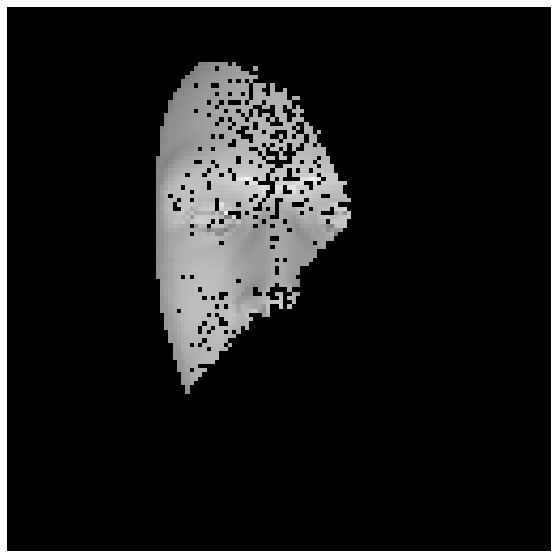

In [8]:
pt_points =  points[0].reshape(3, -1).t()#.to(device)
pt_normals =  normals[0].reshape(3, -1).t()#.to(device)
print(pt_normals.shape, pt_normals.shape)

rgb = torch.ones((pt_points.size(0), 4), device=device) - 0.3


point_cloud = Pointclouds(points=[pt_points], 
                          normals=[pt_normals],
                          features=[rgb])

images = R(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

In [9]:
points.shape

torch.Size([8, 3, 128, 128])

torch.Size([16384, 3]) torch.Size([16384, 3])
torch.Size([16384, 3]) torch.Size([16384, 3])


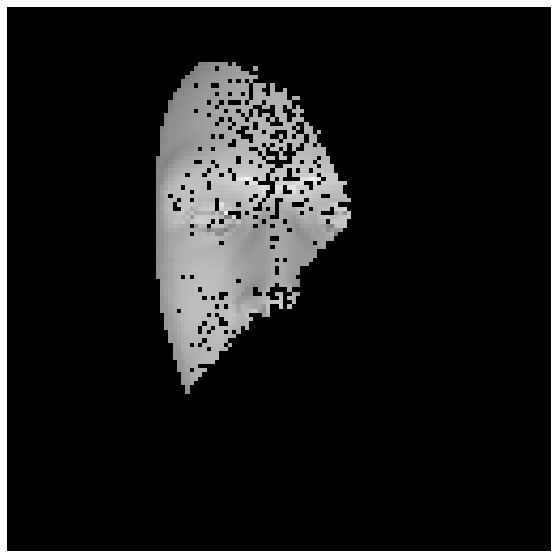

In [10]:
import torch.nn.functional as F

pt_points =  points[0].reshape(3, -1).t()#.to(device)
pt_normals =  normals[0].reshape(3, -1).t()#.to(device)
print(pt_normals.shape, pt_normals.shape)


#  'nearest' | 'linear' | 'bilinear' | 'bicubic' |
scaled_points = F.interpolate(points, scale_factor=1, mode='bicubic', align_corners=True)
scaled_normals = F.interpolate(normals, scale_factor=1, mode='bicubic', align_corners=True)

pt_points =  scaled_points[0].reshape(3, -1).t()#.to(device)
pt_normals =  scaled_normals[0].reshape(3, -1).t()#.to(device)
print(pt_normals.shape, pt_normals.shape)
rgb = torch.ones((pt_points.size(0), 4), device=device) - 0.3
point_cloud = Pointclouds(points=[pt_points], 
                          normals=[pt_normals],
                          features=[rgb])

images = R(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

In [11]:
vertices = G(scaled_points, scaled_normals, style)    
vertices.shape

torch.Size([8, 3, 128, 128])

In [12]:
from src.util import make_faces
_, _, w, h = vertices.shape
faces = torch.tensor(make_faces(w, h)).cpu()
faces

tensor([[    0,     1,   128],
        [    1,   129,   128],
        [    1,     2,   129],
        ...,
        [16254, 16382, 16381],
        [16254, 16255, 16382],
        [16255, 16383, 16382]])

In [20]:
from pytorch3d.structures import Meshes


mesh = Meshes(verts=[vertices[0].reshape(3, -1).t().cpu()], faces=[faces])
mesh

In [19]:
vertices.shape, vertices[0].reshape(3, -1).t().shape

(torch.Size([8, 3, 128, 128]), torch.Size([16384, 3]))

In [24]:
mesh.verts_normals_list()[0].shape

torch.Size([16384, 3])

torch.Size([16384, 3]) torch.Size([16384, 3])


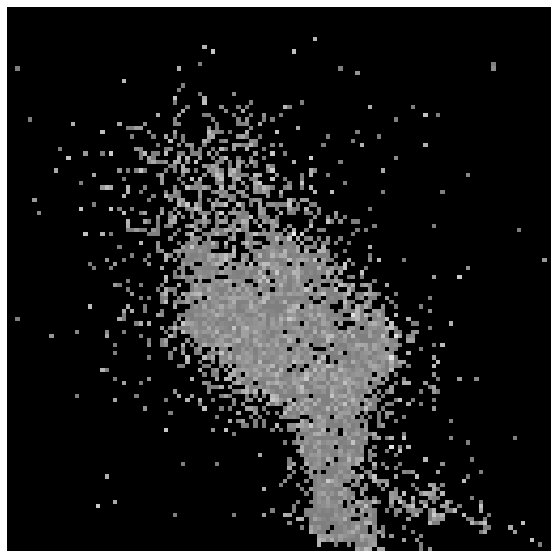

In [28]:
from src.util import make_faces
_, _, w, h = vertices.shape
faces = torch.tensor(make_faces(w, h)).cpu()

gen_points =  vertices[0].reshape(3, -1).t()

mesh = Meshes(verts=[vertices[0].reshape(3, -1).t().detach().cpu()], faces=[faces])


gen_normals =  mesh.verts_normals_list()[0].to(device)
print(pt_normals.shape, pt_normals.shape)
rgb = torch.ones((gen_points.size(0), 4), device=device) - 0.3
point_cloud = Pointclouds(points=[gen_points], 
                          normals=[gen_normals],
                          features=[rgb])

images = R(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().detach().numpy())
plt.grid("off")
plt.axis("off");

In [25]:
mesh.verts_normals_list()[0]

tensor([[-0.4589,  0.3760,  0.8050],
        [ 0.1291, -0.5620, -0.8170],
        [ 0.4577, -0.0175, -0.8889],
        ...,
        [ 0.9751,  0.1932,  0.1085],
        [-0.0477, -0.9330, -0.3567],
        [ 0.3152,  0.1789, -0.9320]], grad_fn=<SplitWithSizesBackward>)